## Using helix_funcs

An example of how to use the helix_funcs module to process the HelixScope datafiles, and generate a master output table.

Process_files should generate a similarly named csv file in the process folder.
combine_processed 

In [1]:
import helix_funcs
import geopandas as gpd
import pandas as pd
# from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#s = gpd.read_file('./data/gadm28_adm1/gadm28_adm1.shp')  # OLD
#s = gpd.read_file("./data/gadm28_adm1_simplified/gadm28_adm1_simplified.shp")   # <--- ADMIN LEVEL 1
#s = gpd.read_file('./data/gadm28_countries/gadm28_countries.shp')  # <--- ADMIN LEVEL 0
#s = gpd.read_file("./data/sanitized_grid/sanitized_grid.shp")  #<-- 10x10 grid
s = gpd.read_file("./data/good_five_grid/good_five_grid.shp")
#s = s.to_crs(epsg='4326')

In [ ]:
fs = helix_funcs.identify_netcdf_and_csv_files()

In [ ]:
fs['nc']

In [ ]:
%%time
for f in ['data/UEA_data/climate/tx/HADGEM3-R1.SWL_15.cl.tx.JJA.nc']:
    helix_funcs.process_file(file=f, shps=s, shape_id='grids5', overwrite=True, verbose=True)

# Note:

Dont process the monthly data, but note that the seasonal data e.g. MAM need to be checked in the parsing, as the variables are not being properly selected.

Also check that all the metadata is being parased when the new country level shapes are uses.

Create 10x10 degree grid to cover the globe. Intersect it with land areas. Create an ID for each shape. Run the pipeline against those shapes to create a coarse gridded dataset.

In [ ]:
test = pd.read_csv("./processed/grids/UEA_data/biodiversity/orchidee-giss-ecearth1.SWL_2.bd.mammalnobiodiversity.csv")

In [ ]:
test.head()

In [ ]:
f = 'data/UEA_data/climate/tx/HADGEM3-R3.SWL_4.cl.tx.MAM.nc'
print(f)
extract_medata_from_filename(f)

In [ ]:
fs

In [ ]:
seasons = ["MAM", "JJA", "SON", "DJF"]

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

### Speed up 

Looks like we achieve a 34 second execution per file (down from 2 mins) when we use a simplifed set of geometries.



## Investiage areas with no zonal stats

Seems like small areas are failing. Need to investigate best way to handle this.

* check simple shapes produce same number of elements as complex shapes - confimred
* check shapefile has same number of shapes as output file - confirmed
* check simple and complex processed results for same file show good agreement. - confirmed

* Add kwarg for ADMIN0 or Admin1. Have a differnt root folder for both in processed data.
* MOVE alredy processed ADMIN1 level data to the `processed/admin1/` directory - Failed. Columns changed. Will need to recalculate :(
* SIMPLIFY the ADMIN-0 level geometry file as I did with the ADMIN1 file. - confirmed
* RUN ADMIN0 for all data.

Perhaps we should have two tables: ADMIN0 level (based on simplified shapes), and ADMIN1 level.

The ADMIN 0 level makes sense to calculate (mean, min, max, stdev), as those shapes should be large. BUT for ADMIN 1 level, the shapes can be far smaller. In which case it doesnt make sense to calculate those stats for every shape.

* given time, we could work out which shapes it makes sense for (e.g. with counts > 3) and make some distinction.
* with short time (which is the case) it maybe only makes sense to offer mean over those areas (which in most cases will be the mean of 1 cell (i.e. simply the value of the gridcell).


THEREFORE:

1. Process all data to ADMIN 0 (using simplified country shapes)
    * use this as MVP
2. CALCULATE TIME RELATIVE STATISTICS
    * i.e. for datatets with Month distinctions calculate the seasonality
3. Attempt to do the ADMIN 1 level data.

# Deal with outputs

Reduce significant digits. Join together dataframes.

In [ ]:
fs = helix_funcs.identify_netcdf_and_csv_files()

In [ ]:
len(fs['csv'])

In [2]:
%%time
helix_funcs.combine_processed_results(path='./processed/grids5',
                                      table_name='./master_5x5.csv', drop_szn_mnth=True)  #<-- join all results files together into a master_admin1.csv

Made ./master_5x5.csv: 626,693 rows of data. 494 sources.
CPU times: user 15.6 s, sys: 700 ms, total: 16.3 s
Wall time: 19.5 s


In [3]:
tmp = pd.read_csv('./master_5x5.csv')

In [5]:
tmp.shape

(626693, 15)

In [6]:
tmp.head()

,shape_id,variable,swl_info,count,max,min,mean,std,impact_tag,institution,model_long_name,model_short_name,model_taxonomy,is_multi_model_summary,run
0,0,reptilenobiodiversity,6.0,29,0.99,0.42,0.75,0.15,bd,"Tyndall Centre for Climate Change Research, Un...","ECEARTH-R1, ECEARTH-R2, ECEARTH-R3, ECEARTH-R4...",orchidee,orchidee-giss-ecearth4,True,1
1,1,reptilenobiodiversity,6.0,136,0.54,0.25,0.43,0.07,bd,"Tyndall Centre for Climate Change Research, Un...","ECEARTH-R1, ECEARTH-R2, ECEARTH-R3, ECEARTH-R4...",orchidee,orchidee-giss-ecearth4,True,1
2,2,reptilenobiodiversity,6.0,556,0.64,0.29,0.47,0.08,bd,"Tyndall Centre for Climate Change Research, Un...","ECEARTH-R1, ECEARTH-R2, ECEARTH-R3, ECEARTH-R4...",orchidee,orchidee-giss-ecearth4,True,1
3,3,reptilenobiodiversity,6.0,156,0.74,0.31,0.55,0.11,bd,"Tyndall Centre for Climate Change Research, Un...","ECEARTH-R1, ECEARTH-R2, ECEARTH-R3, ECEARTH-R4...",orchidee,orchidee-giss-ecearth4,True,1
4,4,reptilenobiodiversity,6.0,2,0.18,0.17,0.17,0.00,bd,"Tyndall Centre for Climate Change Research, Un...","ECEARTH-R1, ECEARTH-R2, ECEARTH-R3, ECEARTH-R4...",orchidee,orchidee-giss-ecearth4,True,1


In [15]:
reptiles = tmp[tmp['variable'] == 'reptilenobiodiversity']['mean']

In [21]:
for n, rep in enumerate(reptiles):
    if rep > 0.1:
        pass
    else:
        print(n, rep)
        break

38 0.09


In [29]:
x = tmp[tmp['variable'] == var]
x[x['swl_info']==2.0]['mean'].values


array([ 19.86,   2.16,   3.32, ...,  15.73,  17.14,  18.69])

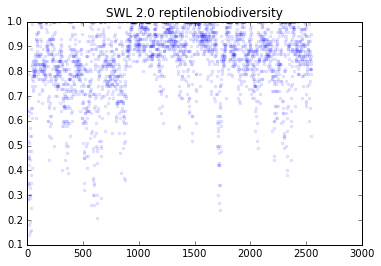

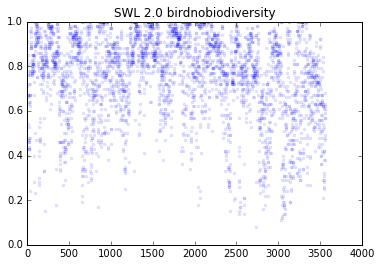

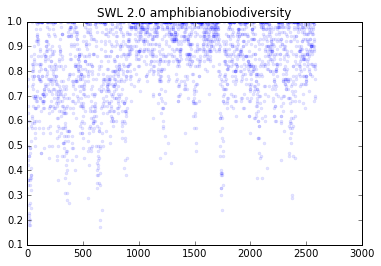

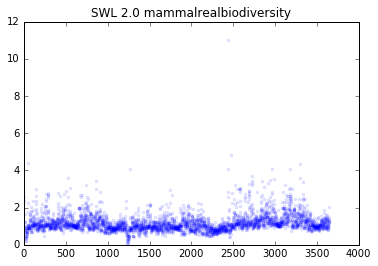

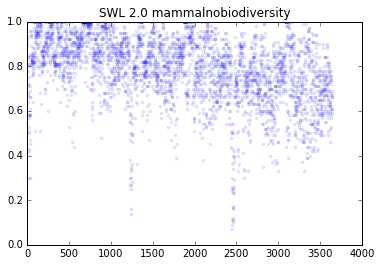

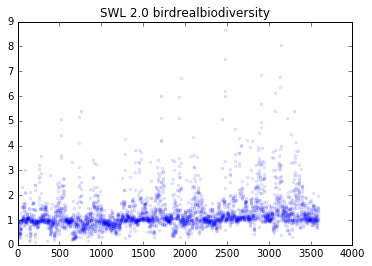

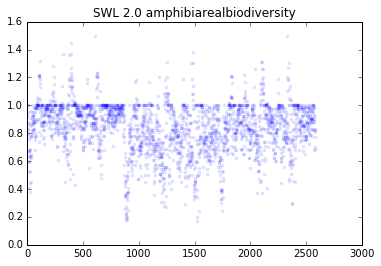

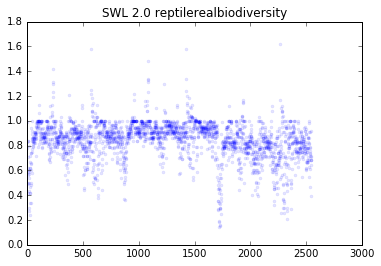

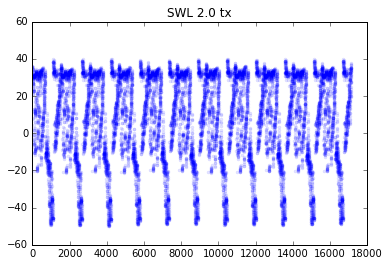

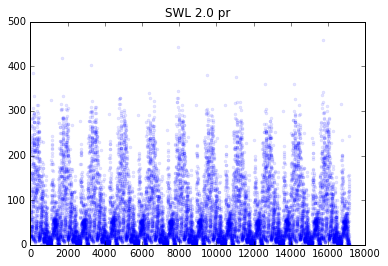

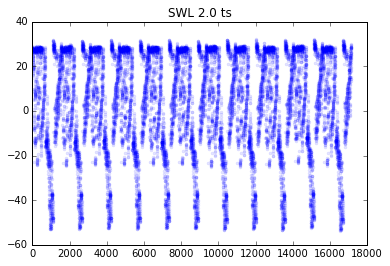

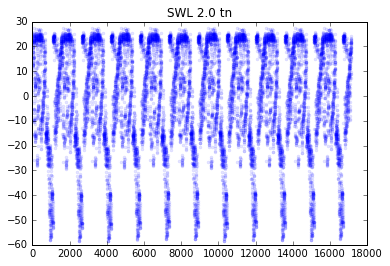

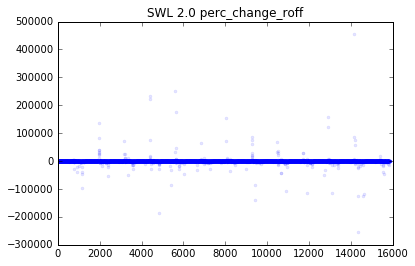

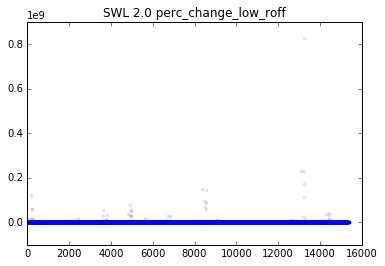

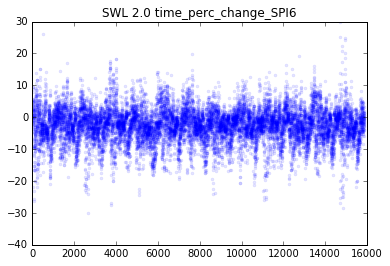

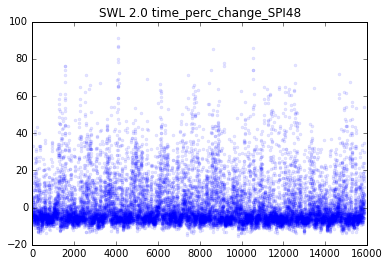

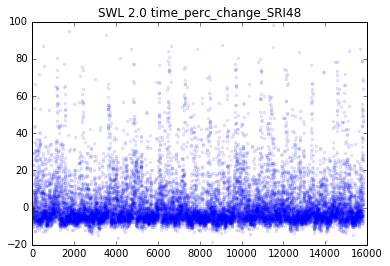

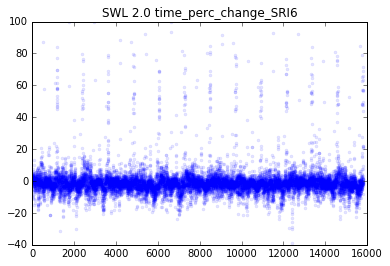

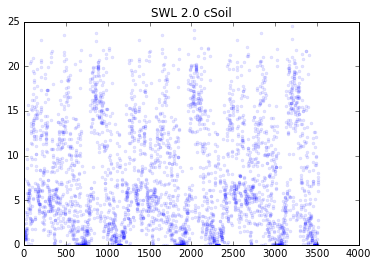

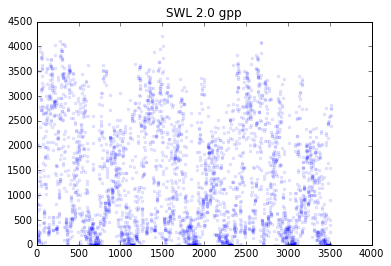

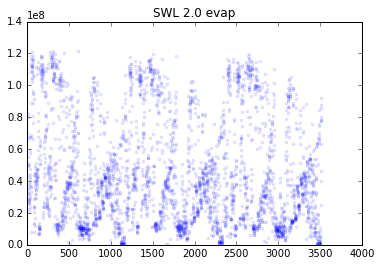

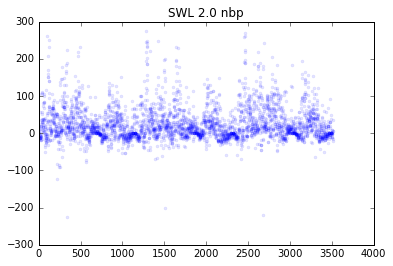

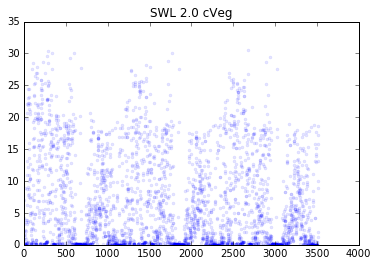

In [32]:
swl_key = 2.0
for var in tmp['variable'].unique():
    x = tmp[tmp['variable'] == var]
    tmp_array = x[x['swl_info']==swl_key]['mean'].values
    plt.plot(tmp_array, 'b.', alpha=0.1)
    plt.title('SWL'+' '+str(swl_key)+' '+var)
    plt.show()

In [ ]:
print(len(tmp['variable'].unique()),'\n')
for var in (tmp['variable'].unique()):
    print(var)

In [ ]:
print(len(tmp['impact_tag'].unique()),'\n')
for var in (tmp['impact_tag'].unique()):
    print(var)

In [ ]:
mask = tmp['variable'] == 'river_floods_PopAff' #'river_floods_PopAff' #"river_floods_ExpDam"
shorter = tmp[mask]
shorter.head()

In [ ]:
sorted(tmp['swl_info'].unique())

In [ ]:
set(tmp['iso'].values)

In [ ]:
is_season = tmp['is_seasonal'] == True
print((len(tmp[is_season])/len(tmp)) * 100.,"% has seasonal data")

In [ ]:
tmp[tmp['is_seasonal']]['variable'].unique()

In [ ]:
tmp[tmp['is_seasonal'] == True]['season'].unique()

In [ ]:
a = 5
if a == 1 or a == 5:
    print('yes')

In [ ]:
is_season = tmp['is_monthly'] == True
print((len(tmp[is_season])/len(tmp)) * 100.,"% has monthly data")

In [ ]:
output_files = helix_funcs.identify_netcdf_and_csv_files('processed/')

In [ ]:
len(output_files['csv'])

In [ ]:
tmp = pd.read_csv(outputs['csv'][-1])

In [ ]:
country_mask = tmp['iso'] == 'ESP'

In [ ]:
tmp = tmp[country_mask].head()

In [ ]:
admin_mask = tmp['id_1'] == 1

In [ ]:
tmp['id_1'].unique()

## Test plots

We need to make an easy way to preview how a specific variables choropleths will appear.
This means read a file, and make a preview plot using geopandas.


In [ ]:
output_files = helix_funcs.identify_netcdf_and_csv_files('processed/')

In [ ]:
helix_funcs.map_file_by_iso(f=output_files['csv'][10], s=s, iso='FRA')

## SIMPLIFY LIFE!

Before passing the polygons for zonal analysis, they should be simplified. 
Looks like the call should be `stest.geometry.simplify(0.2, preserve_topology=False)`

The geometry files themsevels should be simplified, and read in already done. I have another notebook to simply (and correct) these data.

In [ ]:
stest.geometry.simplify(0.2, preserve_topology=False).plot()

In [ ]:
stest = s[s['iso'] == 'BRA']
stest.geometry.plot()

In [ ]:
stest.geometry.simplify(0.2, preserve_topology=True).plot()

## Next Step

Work out problem of small shapes (probably will need to have a logical test for small shapes, and buffer the geom before zonal stats are calculated). Perhaps this should even be done prior to any loop, initially when the shapes are calculaed.

First can look and see what admins are absent from file (to see where the problem lies).

Test with simplifed shapes.

#### REDUCE SIZE OF FINAL DATA BY removing significant digits from values
e.g. 10.6466969914 should be converted to simply 10.6





In [ ]:
def combine_processed_results(path='./processed/admin1',
                              table_name="./master_admin1.csv"):
    """Combine all the csv files in the path (e.g. all processed files)
    into a single master table
    """
    output_files = identify_netcdf_and_csv_files(path)
    frames = [pd.read_csv(csv_file) for csv_file in output_files['csv']]
    master_table = pd.concat(frames)
    master_table.to_csv(table_name, index=False)
    print("Made {0}: {1:,g} rows of data. {2:,g} sources.".format(table_name,
                                                        len(master_table),
                                                        len(output_files['csv'])
                                                                 ))
    return


In [ ]:
path='./processed'
output_files = helix_funcs.identify_netcdf_and_csv_files(path)
frames = [pd.read_csv(csv_file) for csv_file in output_files['csv'][0:10]]

In [ ]:
for  n, frame in enumerate(frames):
    print(n, min(frames[0]['min']), max(frames[0]['min']), min(frames[0]['max']), max(frames[0]['max']), )

In [ ]:
frames[0].head()

In [ ]:
test = frames[0].round(1)

In [ ]:
admin_level = 0

if admin_level == 0:
    admin_prefix = 'admin0/'
elif admin_level == 1:
    admin_prefix = 'admin1/'
else:
    raise ValueError("admin_level kwarg must be either 0 or 1")
print(admin_prefix)

### Test new land shapes

In [ ]:
import geopandas as gpd

In [ ]:
test = gpd.read_file('./data/sanitized_grid/sanitized_grid.shp')

In [ ]:
test.head()

In [ ]:
test.geometry[46]

In [ ]:
tmp = test.drop(['featurecla', 'scalerank','id'],axis=1)
tmp.head()

In [ ]:
len(tmp)

In [ ]:
#gs = tmp.geometry

In [ ]:
#tmp_geoms = gs.simplify(0.2, preserve_topology=False)  # removes all little areas (no point calculating)

In [ ]:
tmp['index'] = list(range(len(tmp)))

In [ ]:
tmp.to_file("/Users/Ben/Desktop/my_land_grid/my_land_grid.shp", driver='ESRI Shapefile')

In [ ]:
xstr = tmp.to_json()

In [ ]:
#with open('/Users/Ben/Desktop/my_grd_land.json','w') as f:
#    f.write(xstr)